# Imports, config and logging server

In [1]:
# Standard library
import ast
from copy import deepcopy
from concurrent.futures import ThreadPoolExecutor

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.model_selection import KFold

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Subset

import mlflow
from mlflow.pytorch import load_model

import torchmetrics.functional.regression as R

# Project-specific imports
from default import *
from config import DIRECTORY, PORT
from tools import MLFlowSession
from models.architecture import MLP
from models.processing import StandardScaler
from dataset import FixedPrattTrussDatasetThreeTargets

# Set random state and device
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

device = torch.device(
    'cuda' if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
)

# Set working directory and figure directory
%cd -q {PROJECT_HOME}
figure_dir = os.path.join(os.getcwd(), '022025_experiment/figures')

# Configure MLFlow server
DIRECTORY = DIRECTORY['011']
PORT = PORT['011']
server = MLFlowSession(PORT=PORT, DIRECTORY=DIRECTORY)
server.start()

# Set dataset dirs
bisupported = False
n_input_dims = 64 if bisupported else 65
n_output_dims = 3

loss = 'mse'

train_dataset_dir = r"data/dataset/pratt_truss_bridge_isostatic/1_category_ea"
test_dataset_dir = r"data/dataset/pratt_truss_bridge_isostatic/test"

_validation_ds = FixedPrattTrussDatasetThreeTargets(f"{test_dataset_dir}/uniform_8192.hdf5")

MLflow server started at http://127.0.0.1:5011
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/011/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/011
Workers: 4
Process group: 42009


# Training procedure

In [2]:
def train_step(model, batch, input_scaler, target_scaler, optimizer, criterion):
    model.train()

    input, target, _, _, _ = batch
    input, target = input.to(device), target.to(device)

    z_input = input_scaler.transform(input)
    z_target = target_scaler.transform(target)

    z_target_pred = model(z_input)
    target_pred = target_scaler.inverse_transform(z_target_pred)

    optimizer.zero_grad()
    loss = criterion(z_target_pred, z_target)
    loss.backward()
    optimizer.step()

    metrics = compute_metrics(model, target_pred, z_target_pred, target, z_target)
    metrics['loss'] = loss.item()

    return metrics


def validation(model, batch, input_scaler, target_scaler, criterion):
    model.eval()
    with torch.no_grad():
        input, target, _, _, _ = batch
        input, target = input.to(device), target.to(device)

        z_input = input_scaler.transform(input)
        z_target = target_scaler.transform(target)

        z_target_pred = model(z_input)
        target_pred = target_scaler.inverse_transform(z_target_pred)

        loss = criterion(z_target_pred, z_target)

    metrics = compute_metrics(model, target_pred, z_target_pred, target, z_target)
    metrics['loss'] = loss.item()

    return metrics


def compute_metrics(model, target_pred, z_target_pred, target, z_target):
    model.eval()

    with torch.no_grad():
        r2 = R.r2_score(z_target_pred, z_target)
        if r2.isinf():  # Switch to 64 bits in case of overflow
            r2 = R.r2_score(target_pred.cpu().to(torch.float64), target.cpu().to(torch.float64))
        mape = R.mean_absolute_percentage_error(target_pred, target)
        rmse = R.mean_squared_error(target_pred * 1e-6, target * 1e-6, squared=False)
        if rmse.isinf():  # Switch to 64 bits in case of overflow
            rmse = R.mean_squared_error(target_pred.cpu().to(torch.float64), target.cpu().to(torch.float64),
                                        squared=False)

    return {'r2': r2, 'mape': mape, 'rmse_MN': rmse}


def log_epoch(train_metrics, val_metrics, epoch):
    metrics = dict()
    metrics.update({f'train_{k}': v for k, v in train_metrics.items()})
    metrics.update({f'val_{k}': v for k, v in val_metrics.items()})

    mlflow.log_metrics(metrics, step=epoch)


def log_model(name, model, signature, metadata=None):
    mlflow.pytorch.log_model(
        pytorch_model=model,
        artifact_path=name,
        signature=signature,
        metadata=metadata
    )


def console_log(epoch, train_metrics, val_metrics):
    print(f">> Epoch {epoch + 1:4d}", end='  ')
    print(f"TRAIN", end='   ')
    metric_names = {k for k in train_metrics.keys() if k != 'loss'}
    metric_names = ['loss'] + sorted(metric_names)
    for k in metric_names:
        v = train_metrics[k]
        print(f"{k}: {v: 1.4f}", end='   ')

    print("  ||  ", end='')
    print(f"VALIDATION", end='   ')
    metric_names = {k for k in val_metrics.keys() if k != 'loss'}
    metric_names = ['loss'] + sorted(metric_names)
    for k in metric_names:
        v = val_metrics[k]
        print(f"{k}: {v: 1.4f}", end='   ')
    print()


def train(model, train_dataset, val_dataset, train_batch_size, val_batch_size, n_epoch, optimizer, criterion,
          log_step=10):
    model = model.to(device)
    criterion = criterion.to(device)
    train_dl = DataLoader(train_dataset, train_batch_size, shuffle=True)
    val_dl = DataLoader(val_dataset, val_batch_size, shuffle=False)

    input_scaler = StandardScaler(train_dataset[0][0].__len__()).to(device)
    target_scaler = StandardScaler(train_dataset[0][1].__len__()).to(device)

    # Train the scaler
    input, target = None, None
    for batch in train_dl:
        input, target, _, _, _ = batch
        input, target = input.to(device), target.to(device)
        input_scaler.partial_fit(input)
        target_scaler.partial_fit(target)

    signature = mlflow.models.infer_signature(input.cpu().detach().numpy(),
                                              input_scaler.transform(input).cpu().detach().numpy())
    log_model('input_scaler', input_scaler, signature=signature)

    signature = mlflow.models.infer_signature(target.cpu().detach().numpy(),
                                              target_scaler.transform(target).cpu().detach().numpy())
    log_model('target_scaler', target_scaler, signature=signature)

    best_val_metric = {
        'mape': {model: None, 'value': np.inf, 'epoch': -1},
        'rmse_MN': {model: None, 'value': np.inf, 'epoch': -1},
        'loss': {model: None, 'value': np.inf, 'epoch': -1},
        'r2': {model: None, 'value': -np.inf, 'epoch': -1}
    }

    for epoch in range(n_epoch):
        train_metrics = {}
        val_metrics = {}
        for batch in train_dl:
            train_metrics_epoch = train_step(model, batch, input_scaler, target_scaler, optimizer, criterion)
            for k, m in train_metrics_epoch.items():
                if k not in train_metrics: train_metrics[k] = []
                train_metrics[k].append(m)

        for batch in val_dl:
            val_metrics_epoch = validation(model, batch, input_scaler, target_scaler, criterion)
            for k, m in val_metrics_epoch.items():
                if k not in val_metrics: val_metrics[k] = []
                val_metrics[k].append(m)

        # Compute the mean on GPU  -> Faster for batch
        train_metrics = {name: torch.tensor(metrics, device=device, dtype=torch.float32).mean() for name, metrics in
                         train_metrics.items()}
        val_metrics = {name: torch.tensor(metrics, device=device, dtype=torch.float32).mean() for name, metrics in
                       val_metrics.items()}

        log_epoch(train_metrics, val_metrics, epoch + 1)

        negative_metrics = {'r2'}  # Set of metrics which are better when higher

        for k, v in val_metrics.items():
            f = 1 if k not in negative_metrics else -1
            if f * best_val_metric[k]['value'] >= f * v:
                best_val_metric[k] = {'model': deepcopy(model), 'value': v.item(), 'epoch': epoch + 1}

        if (log_step < 0): continue
        if (epoch % log_step == 0):
            console_log(epoch + 1, train_metrics, val_metrics)

    input, target, _, _, _ = train_dl.__iter__().__next__()
    signature = mlflow.models.infer_signature(input.cpu().detach().numpy(), target.cpu().detach().numpy())
    for k, v in best_val_metric.items():
        metric = v['value']
        epoch = v['epoch']
        log_model(f"{k}_model", v['model'], signature=signature, metadata={'metric': metric, 'epoch': epoch + 1})


def trial_routine(run_name, train_routine, mlp_params, train_dataset, val_dataset, train_batch_size,
                  val_batch_size, n_epoch, optimizer, lr, criterion, fold, log_step=10, log_params=None):
    with mlflow.start_run(run_name=run_name):
        # Model initialization
        model = MLP(**mlp_params)

        # Model information logging
        capacity = sum(np.prod(p.size()) for p in filter(lambda p: p.requires_grad, model.parameters()))
        if log_params is not None:
            mlflow.log_params(log_params)
        mlflow.log_params(mlp_params)
        mlflow.log_params({
            'n_hidden_layers': len(mlp_params['hidden_dims']),
            'hidden_layers_size': mlp_params['hidden_dims'][0],
            'capacity': capacity,
            'n_epoch': n_epoch,
            'val_batch_size': val_batch_size,
            'train_batch_size': train_batch_size,
            'train_size': train_dataset.__len__(),
            'val_size': val_dataset.__len__(),
            'k-fold': fold,
            'optimizer': optimizer.__name__,
            'learning_rate': f"{lr:.1e}",
            'criterion': criterion.__name__,
        })

        # Run the training with the configuration
        train_routine(model, train_dataset, val_dataset,
                      train_batch_size, val_batch_size,
                      n_epoch, optimizer(model.parameters(), lr=lr), criterion(), log_step=log_step)

In [3]:
def plot(results, configs, metrics, labels, logs=None, xlim=None, ylim=None, figsize=(10, 10)):
    if not isinstance(metrics, list):
        metrics = [metrics]
    if logs is None:
        logs = [True] * len(metrics)
    elif not isinstance(logs, list):
        logs = [logs] * len(metrics)

    cmap = mpl.colormaps['tab10']
    c = cmap(np.linspace(0, 1, len(configs)))

    if len(metrics) == 1:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
        axs = [ax]
    else:
        fig, axs = plt.subplots(nrows=int(np.ceil(len(metrics) / 2)), ncols=2, figsize=figsize)
        axs = [ax for row in axs for ax in row]

    for i, (metric, log) in enumerate(zip(metrics, logs)):
        ax = axs[i]
        # Plot the data but collect the handles for the legend
        config_handles = []
        for i, conf in enumerate(configs):
            # Store only the validation line handles for the legend
            l = len(results[conf][f'train_{metric}'])
            h = ax.plot(np.arange(l), results[conf][f'train_{metric}'], alpha=.5, ls='--', lw=1, c=c[i])[0]
            h2 = ax.plot(np.arange(l), results[conf][f'val_{metric}'], ls='-', lw=1, c=c[i])[0]
            config_handles.append(h2)

        # Create custom handles for the line style legend
        line_style_handles = [
            Line2D([0], [0], color='black', lw=1, ls='--', alpha=0.5, label='Training'),
            Line2D([0], [0], color='black', lw=1, ls='-', label='Validation'),
            Line2D([0], [0], color='black', alpha=0, lw=1, ls='-')
        ]

        # Get the current position and size of the axis
        box = ax.get_position()
        # Reduce the width of the axis to make room for the legend
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Combine both sets of handles and labels
        all_handles = line_style_handles + config_handles
        all_labels = ['Training', 'Validation', ''] + labels

        # Create a single legend with both line styles and configurations
        plt.figlegend(all_handles, all_labels, loc='center left', bbox_to_anchor=(1, .5),
                      title="Legend")

        ax.set_title(f"Evolution of {metric} during training")
        if log:
            ax.set_yscale('log')
        ax.set_ylabel(f"{metric} [/]")
        ax.set_xlabel("epoch [/]")

        if xlim: ax.set_xlim(*xlim)
        if ylim: ax.set_ylim(*ylim)

    fig.tight_layout(h_pad=2, w_pad=7.5)
    # Adjust right padding to make room for the legend
    plt.show()

# Hyper-parameter tuning

In [4]:
TRAIN_BATCH_SIZE = 512
VAL_BATCH_SIZE = 512
kfold = 10

N_EPOCH = 200
LR = 5e-4

log_step = -1

ds = FixedPrattTrussDatasetThreeTargets(f"{train_dataset_dir}/train_4096.hdf5")
mlflow.set_tracking_uri(uri=server.url())

## Model capacity

In [5]:
%%capture
mlflow.set_experiment("capacity")

n_layers_values = [2, 3, 4, 5]
n_neurons_values = [65, 70, 80, 100, 120]
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for n_layers in n_layers_values:
        for n_neurons in n_neurons_values:
            for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
                hidden_dims = [n_neurons for _ in range(n_layers)]
                train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
                future = executor.submit(trial_routine, None, train,
                                         {
                                             'input_dim': n_input_dims,
                                             'hidden_dims': hidden_dims,
                                             'output_dim': n_output_dims,
                                             'activation': "relu",
                                             'activation_params': None,
                                             'dropout': 0.0,
                                             'batch_norm': False,
                                             'layer_norm': False,
                                             'normalization_params': None,
                                             'output_activation': None,
                                             'output_activation_params': None,
                                         },
                                         train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                         N_EPOCH,
                                         torch.optim.Adam, LR, nn.MSELoss, kfold, log_step, {'loss': loss})
                futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

In [6]:
experiment = mlflow.get_experiment_by_name("capacity")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

layers_combinations = set()
for n_layers in runs_df['params.n_hidden_layers'].unique():
    for layer_size in runs_df['params.hidden_layers_size'].unique():
        layers_combinations.add((n_layers, layer_size))

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in layers_combinations}
for n, size in layers_combinations:
    run_ids = runs_df[
        (runs_df['params.loss'] == 'mse') &
        (runs_df['params.n_hidden_layers'] == n) &
        (runs_df['params.hidden_layers_size'] == size)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[(n, size)][metric_name].append(
                [metric.value for metric in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

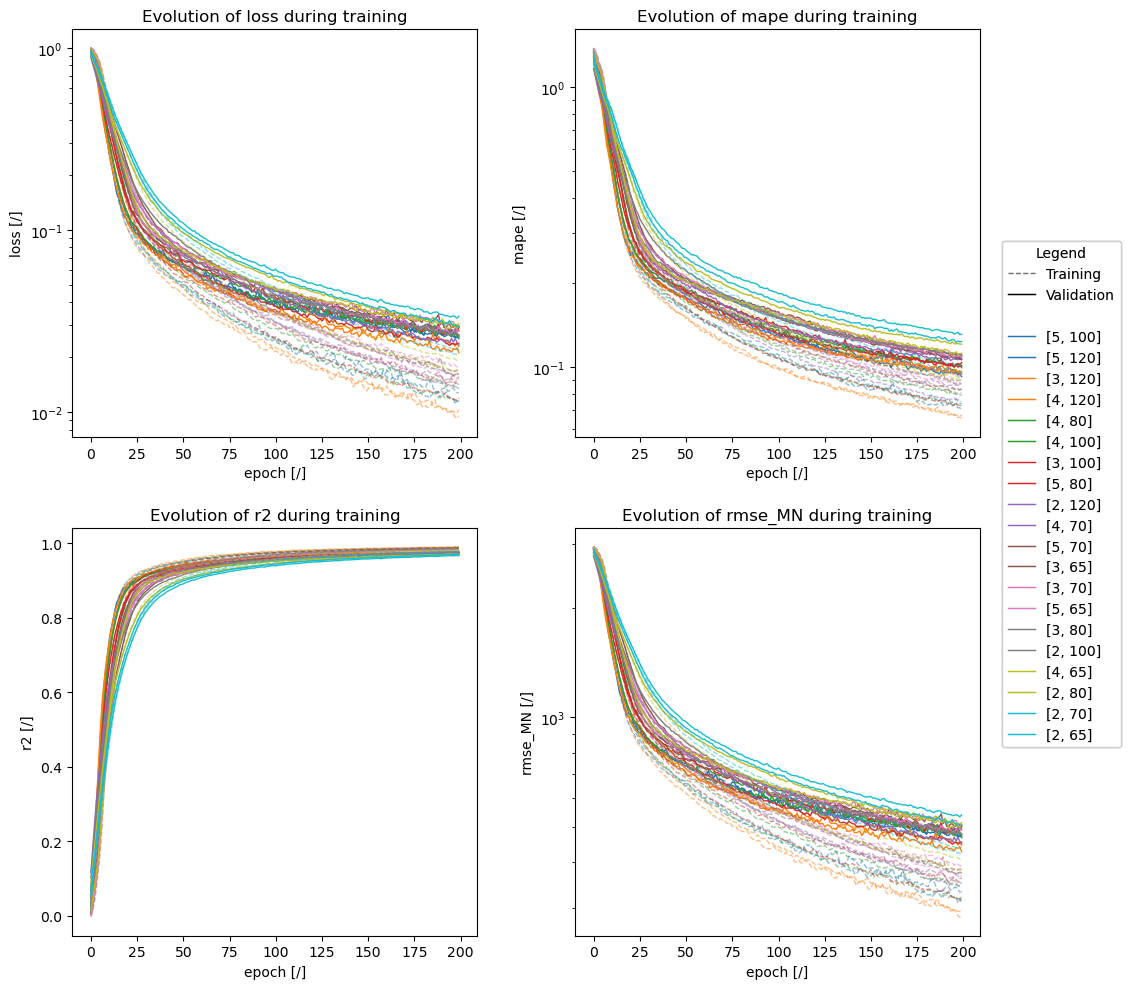

In [7]:
# Your existing code for preparing the data
configs_by_val_mape = sorted([(np.min(v['val_mape']), k) for k, v in results.items()])
configs = configs_by_val_mape

configs = sorted(configs)
configs = [x[1] for x in configs]

labels = [str([int(x) for x in cfg]) for cfg in configs]

plot(results, configs, ['loss', 'mape', 'r2', 'rmse_MN'], labels, logs=[True, True, False, True])

In [8]:
# Pareto front technique
best_mape = configs_by_val_mape[0][0]
candidates = [x[1] for x in filter(lambda x: x[0] <= best_mape * 1.02, configs_by_val_mape)]

filtered_results = {k: results[k] for k in candidates}

configs_by_val_rmse = sorted([(np.min(v['val_rmse_MN']), k) for k, v in filtered_results.items()])
best_candidate = [int(x) for x in configs_by_val_rmse[0][1]]
best_hidden_dims = [best_candidate[1]] * best_candidate[0]

print(f"Best candidate is: {best_candidate} according to the pareto front.")

Best candidate is: [5, 100] according to the pareto front.


In [9]:
to_delete = [
    'n_layers_values', 'n_neurons_values', 'executor', 'futures', 'n_layers', 'n_neurons',
    'fold', 'train_idx', 'val_idx', 'hidden_dims', 'train_dataset', 'validation_dataset',
    'future', 'experiment', 'runs_df', 'cols', 'metrics_names', 'layers_combinations',
    'client', 'results', 'n', 'size', 'run_ids', 'run_id', 'metric_name', 'k',
    'configs_by_val_mape', 'configs', 'labels', 'best_mape', 'candidates',
    'filtered_results', 'configs_by_val_rmse', 'best_candidate'
]

for var in to_delete:
    try:
        globals().pop(var, None)
    except KeyError:
        continue


## Activation function

In [10]:
%%capture
mlflow.set_experiment("activation_function")

activation_values = ['relu', 'gelu', 'tanh', 'sigmoid',
                     'leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu']
activation_params_values = [None, None, None, None,
                            {'negative_slope': 5e-1}, {'negative_slope': 1e-1}, {'negative_slope': 5e-2},
                            {'negative_slope': 1e-2}]

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for activation, activation_params in zip(activation_values, activation_params_values):
        for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=kfold, shuffle=True).split(ds)):
            train_dataset, validation_dataset = Subset(ds, train_idx), Subset(ds, val_idx)
            future = executor.submit(trial_routine, None, train,
                                     {
                                         'input_dim': n_input_dims,
                                         'hidden_dims': best_hidden_dims,
                                         'output_dim': n_output_dims,
                                         'activation': activation,
                                         'activation_params': activation_params,
                                         'dropout': 0.0,
                                         'batch_norm': False,
                                         'layer_norm': False,
                                         'normalization_params': None,
                                         'output_activation': None,
                                         'output_activation_params': None,
                                     },
                                     train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                     N_EPOCH,
                                     torch.optim.Adam, LR, nn.MSELoss, kfold, log_step, {'loss': loss})
            futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

In [11]:
experiment = mlflow.get_experiment_by_name("activation_function")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

activations_combinations = set()
for m in runs_df['params.activation'].unique():
    for n in runs_df[runs_df['params.activation'] == m]['params.activation_params'].unique():
        activations_combinations.add((m, n))

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in activations_combinations}
for k in activations_combinations:
    (act, params) = k
    run_ids = runs_df[
        (runs_df['params.loss'] == 'mse') &
        (runs_df['params.activation'] == act) &
        (runs_df['params.activation_params'] == params)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[k][metric_name].append([m.value for m in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

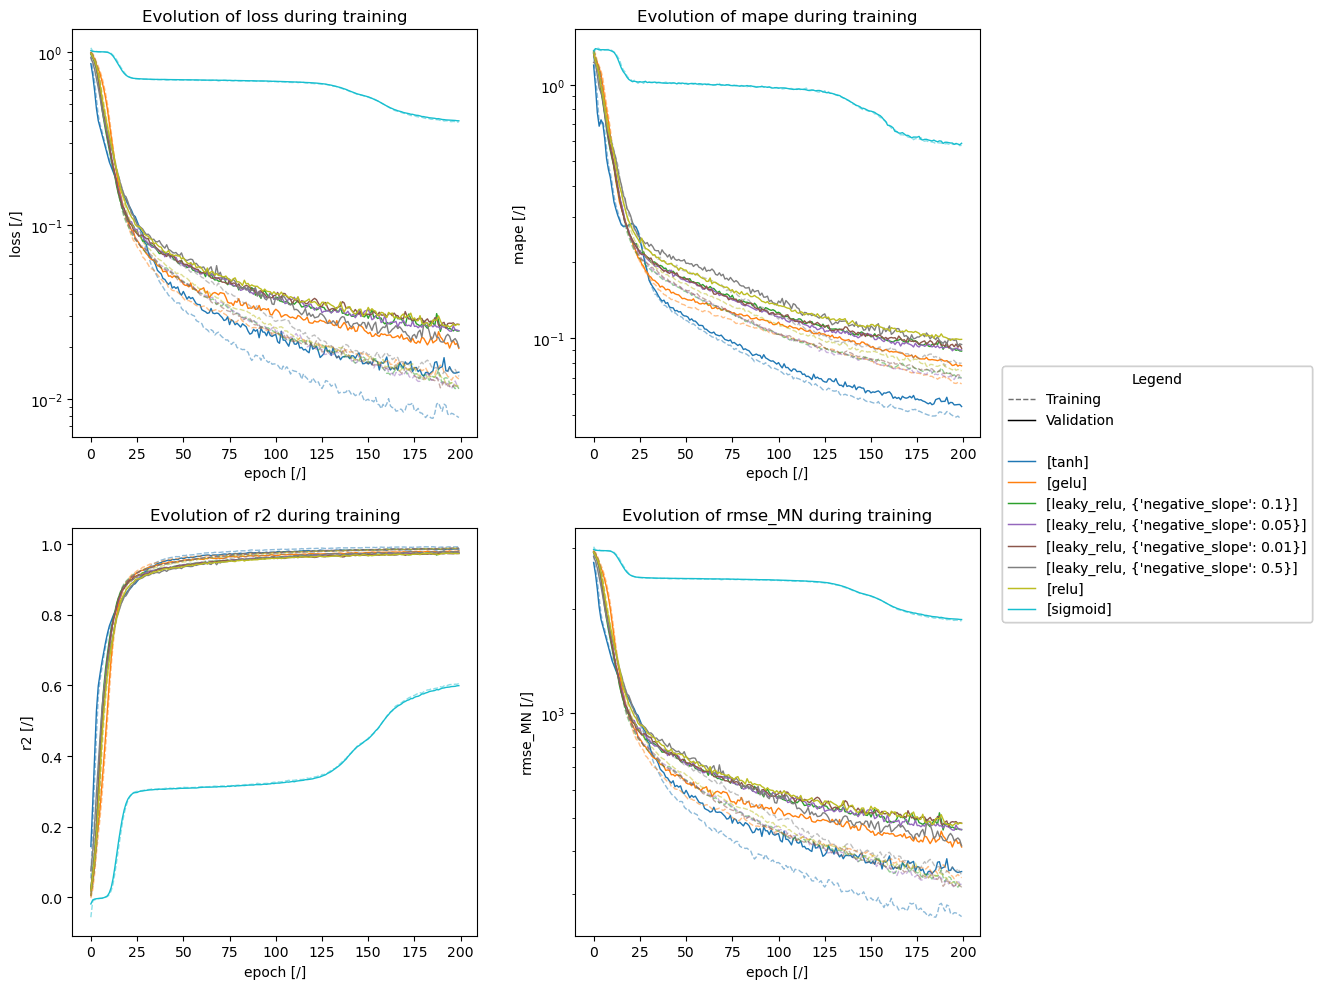

In [12]:
configs_by_val_mape = sorted([(np.min(v['val_mape']), k) for k, v in results.items()])

configs = [x[1] for x in configs_by_val_mape]

labels = [f"[{cfg[0]}]" if cfg[1] == 'None' else f"[{cfg[0]}, {cfg[1]}]" for cfg in configs]

plot(results, configs, ['loss', 'mape', 'r2', 'rmse_MN'], labels, logs=[True, True, False, True])

In [13]:
# Pareto front technique
best_mape = configs_by_val_mape[0][0]
candidates = [x[1] for x in filter(lambda x: x[0] <= best_mape * 1.02, configs_by_val_mape)]

filtered_results = {k: results[k] for k in candidates}

configs_by_val_rmse = sorted([(np.min(v['val_rmse_MN']), k) for k, v in filtered_results.items()])

best_candidate = configs_by_val_rmse[0][1]
best_activation = best_candidate[0]
best_activation_params = ast.literal_eval(best_candidate[1])

print(f"Best candidate is: {best_candidate} according to the pareto front.")

Best candidate is: ('tanh', 'None') according to the pareto front.


In [14]:
to_delete = [
    'activation_values', 'activation_params_values', 'executor', 'futures',
    'activation', 'activation_params', 'fold', 'train_idx', 'val_idx',
    'train_dataset', 'validation_dataset', 'future', 'experiment', 'runs_df',
    'cols', 'metrics_names', 'activations_combinations', 'client', 'results',
    'k', 'act', 'params', 'run_ids', 'run_id', 'metric_name', 'configs_by_val_mape',
    'configs', 'labels', 'best_mape', 'candidates', 'filtered_results',
    'configs_by_val_rmse', 'best_candidate'
]

for var in to_delete:
    try:
        del globals()[var]
    except KeyError:
        pass

## Learning rate

In [15]:
best_learning_rate = 1e-3

# Training final model

## Training

In [16]:
%%capture
mlflow.set_experiment("training")

VAL_BATCH_SIZE = 8192
N_EPOCH = 1_000
log_step = -1

sizes = [2 ** i for i in range(8, 15)]
batch_size_values = [512 for _ in sizes]
dataset_path_values = [f"{train_dataset_dir}/train_{n}.hdf5" for n in sizes]

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for i, (dataset_path, TRAIN_BATCH_SIZE) in enumerate(zip(dataset_path_values, batch_size_values)):
        size = sizes[i]
        train_dataset = FixedPrattTrussDatasetThreeTargets(dataset_path)
        validation_dataset = _validation_ds
        future = executor.submit(trial_routine, None, train,
                                 {
                                     'input_dim': n_input_dims,
                                     'hidden_dims': best_hidden_dims,
                                     'output_dim': n_output_dims,
                                     'activation': best_activation,
                                     'activation_params': best_activation_params,
                                     'dropout': 0.0,
                                     'batch_norm': False,
                                     'layer_norm': False,
                                     'normalization_params': None,
                                     'output_activation': None,
                                     'output_activation_params': None
                                 },
                                 train_dataset, validation_dataset, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE,
                                 N_EPOCH,
                                 torch.optim.Adam, best_learning_rate, nn.MSELoss,
                                 -1, log_step, {'loss': loss, 'noise': 0.})
        futures.append(future)

    # Ensure all processes complete execution
    for future in futures:
        future.result()

In [17]:
experiment = mlflow.get_experiment_by_name("training")

runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

sizes = set()
for size in runs_df['params.train_size'].unique():
    sizes.add(size)

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in sizes}
for size in sizes:
    run_ids = runs_df[
        (runs_df['params.loss'] == 'mse') &
        (runs_df['params.train_size'] == size)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[size][metric_name].append([m.value for m in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

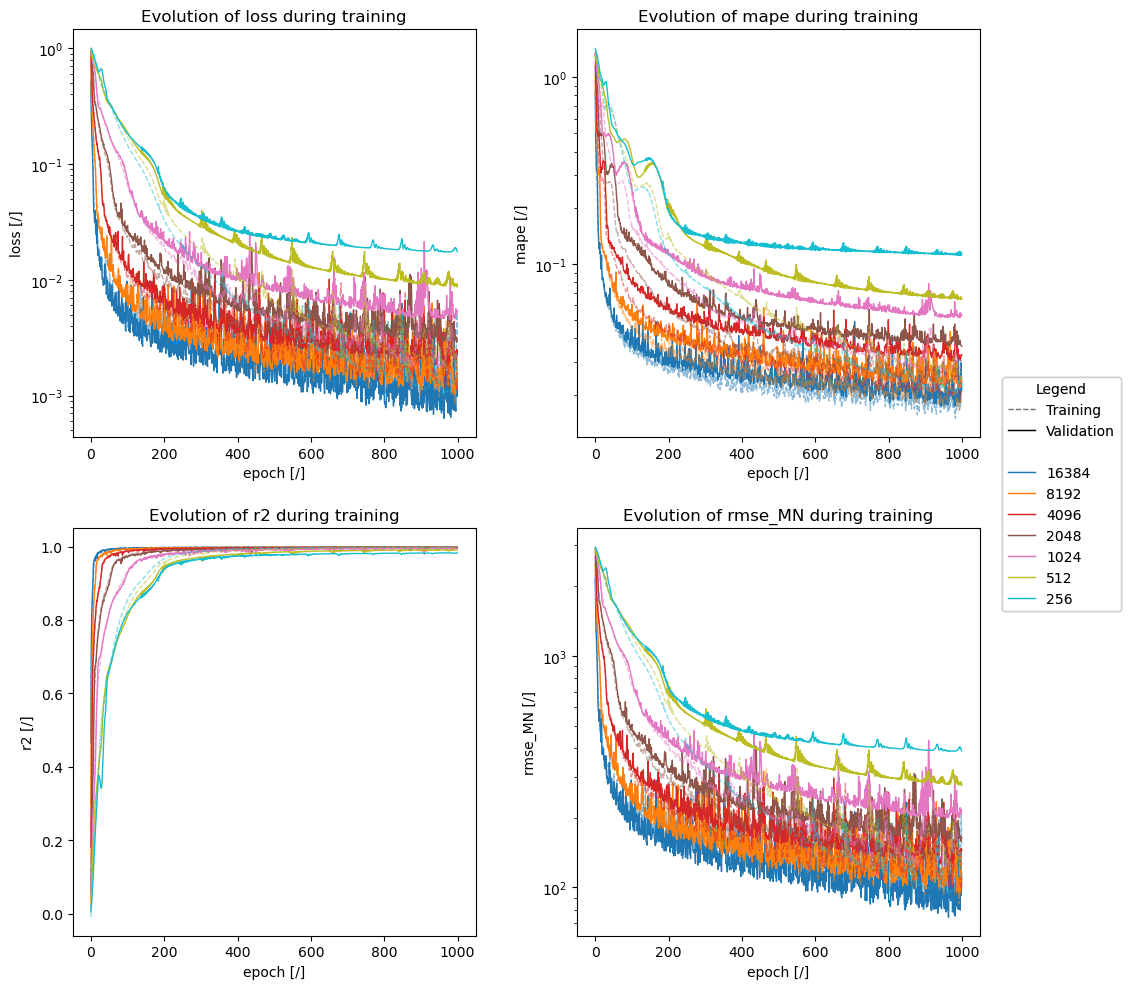

In [18]:
configs = sorted([(np.min(v['val_mape']), k) for k, v in results.items()])
configs = [x[1] for x in configs]

labels = [f"{int(size)}" for size in configs]

plot(results, configs, ['loss', 'mape', 'r2', 'rmse_MN'], labels, logs=[True, True, False, True])

## Noise sensitivity

In [19]:
%%capture
experiment = mlflow.get_experiment_by_name("training")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
runs_df = runs_df[runs_df['params.loss'] == 'mse']

results = []

for f in np.linspace(0, .1, 6):
    validation_ds = FixedPrattTrussDatasetThreeTargets(
        "data/dataset/pratt_truss_bridge_isostatic/test/uniform_8192.hdf5",
        f_noise_length=None,
        f_noise_loads=lambda size: 1. + np.random.exponential(f / 2, size=size) * (
                (np.random.binomial(1, .5, size=size) * 2.) - 1),
        f_noise_strain=lambda size: 1. + np.random.exponential(f / 2, size=size) * (
                (np.random.binomial(1, .5, size=size) * 2.) - 1),
        f_noise_displacement=lambda size: 1. + np.random.exponential(f / 2, size=size) * (
                (np.random.binomial(1, .5, size=size) * 2.) - 1),
    )

    dl = DataLoader(validation_ds, batch_size=8192)

    for i in range(len(runs_df[['artifact_uri', 'params.train_size']])):
        artifact_uri = runs_df.iloc[i]['artifact_uri']
        size = runs_df.iloc[i]['params.train_size']

        uri = f"{artifact_uri}/input_scaler/"
        input_scaler = load_model(uri)

        uri = f"{artifact_uri}/target_scaler/"
        target_scaler = load_model(uri)

        uri = f"{artifact_uri}/mape_model/"
        model = load_model(uri)

        for batch in dl:
            metrics = validation(model, batch, input_scaler, target_scaler, F.mse_loss)
        results.append((size, f, metrics))

In [20]:
%%capture
mlflow.set_experiment("noise_sensitivity")

df = pd.DataFrame([[results[i][0], results[i][1],
                    results[i][2]['r2'].item(),
                    results[i][2]['mape'].item(),
                    results[i][2]['rmse_MN'].item(),
                    results[i][2]['loss']]
                   for i in range(len(results))], columns=['train_size', 'noise', 'r2', 'mape', 'rmse_MN', 'loss'])
df.sort_values(by=['train_size', 'noise'], axis=0, ignore_index=True, inplace=True)

for size in df.train_size.unique():
    with mlflow.start_run():
        df_2 = df[df['train_size'] == size]
        # Model information logging
        mlflow.log_params({
            'train_size': size,
            'loss': loss,
            'test_set': 'single_ea'
        })
        for i in range(len(df_2)):
            mlflow.log_metrics(
                dict(df_2.iloc[i][1:]),
                step=i
            )

# Closing the server

In [21]:
server.terminate()